# raw data to dataframe

In [269]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir

In [270]:
def readfile (filename):
#     target = ["IDENTIFICATION DATA :", "HISTORY OF PRESENT ILLNESS :",
#            "PAST MEDICAL HISTORY :", "SOCIAL HISTORY :", "PHYSICAL EXAMINATION :"]
    f = open("./data/raw_data/" + filename, "r")
    txt = f.read().splitlines()

    flag = False
    content = ""
    label = filename.split("_")[0]
    _id = filename.split("_")[2].split('.')[0]

    for line in txt:
#         if line in target:
#             flag = True
#             continue
#         elif line[-1:] == ":":
#             flag = False
        if line[-1:] == ":" : 
            flag = True
            continue
        if flag:
            content += (" " + line)
            
    return (content, label, _id)
def files_to_df(files):
    df = pd.DataFrame(columns = ["content", "label", "id"])
    for file in files:
        content, label, _id = readfile(file)
        df = df.append({
            "content": content,
            "label": label,
            "id": _id

        }, ignore_index=True)
    return df

In [271]:
files = listdir("./data/raw_data/")
df = files_to_df(files)
# df.to_csv("./data/raw_data.csv", index=False)


# freq of all content 

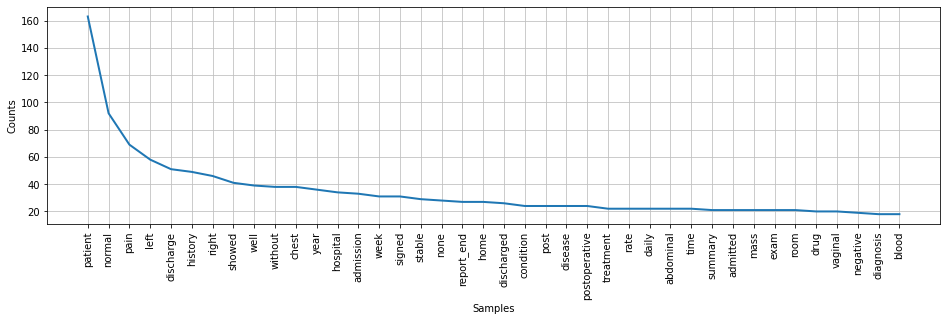

In [336]:
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
# nltk.download("stopwords")
# nltk.download('punkt')
# nltk.download('wordnet')
stopwords = set(stopwords.words('english'))
symbols   = ['.', ',', '’', '“', '”', '"', "''",
             "'", '*', '``', '**', '$', '%', '&', '#',
             '-', '--', "''", '""', '?', '!', ':', ';',
             '(', ')', '[', ']', '{', '}', "/"]
stopwords.update(symbols)

filtered_content = []
lemmatizer = WordNetLemmatizer()

# filter word is not in stopwords
for content in df["content"]:
    filtered_content.append([lemmatizer.lemmatize(word, pos = "n") for word in word_tokenize(content.lower()) 
                             if word not in stopwords])

all_filtered_content = sum(filtered_content, [])
data_analysis = nltk.FreqDist(all_filtered_content)
filter_words = dict([(m, n) for m, n in data_analysis.items() if len(m) > 3]) # len > 3, maybe remove?
fdist_content = nltk.FreqDist(filter_words)
plt.figure(figsize=(16,4))
fdist_content.plot(40,cumulative=False)

# TF-IDF 

In [354]:
# need survey how does TF-IDF work, not yet done
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

corpus = list(df["content"])
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus) 
word = vectorizer.get_feature_names()

transformer = TfidfTransformer()
tfidf = transformer.fit_transform(X)